## Simulation for checking statistical procedures and model fits

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd

### Fake data simulation
Simulation of fake data can be used to validate statistical algorithms and to check the properties of estimation procedures. We illustrate with a simple regression model, where we simulate fake data from the model, y = $\alpha + \beta x + \epsilon$, refit the model to the simulated data, and check the coverage of the 68% and 95% intervals for the coefficent $\beta$.

In [15]:
a, b, s = 1.4, 2.3, 0.9
x = np.arange(1,6,1)
n = len(x)

We then simulate a vector y of fake data and fit a regression model to these data. The fitting makes no use of the true values of $\alpha, \beta$ and $\sigma$.

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.930
Model:                            OLS   Adj. R-squared:                  0.906
Method:                 Least Squares   F-statistic:                     39.61
Date:                Fri, 30 Oct 2020   Prob (F-statistic):            0.00810
Time:                        14:54:06   Log-Likelihood:                -5.9525
No. Observations:                   5   AIC:                             15.90
Df Residuals:                       3   BIC:                             15.12
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.3850      1.077      2.213      0.1

/opt/app-root/lib/python3.6/site-packages/statsmodels/stats/stattools.py:71: ValueWarning: omni_normtest is not valid with less than 8 observations; 5 samples were given.
  "samples were given." % int(n), ValueWarning)


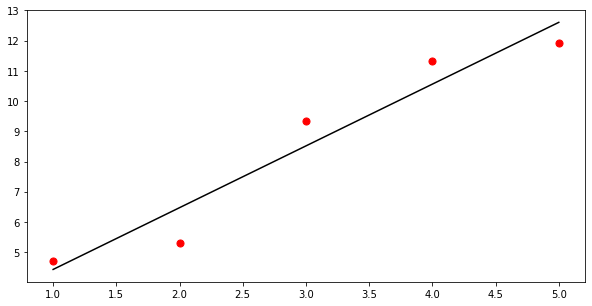

In [16]:
y = a + b*x + np.random.normal(loc=0, scale=s, size=n)
Xa = sm.add_constant(x)  # add ones vector
model = sm.OLS(y, Xa)
res_OLS = model.fit()
params = res_OLS.params
print(res_OLS.summary())
fig, axes = plt.subplots(figsize=(10,5)) 
axes.scatter(x, y, s=50, c='r')
axes.plot(x, params[0]+params[1]*x, 'k')

Comparing the estimated coefficients to the true values 1.4 and 2.3, the fit seems reasonable enough: the estimates are not exact but are within the margin of error. We can perform this comparison more formally by extracting from the regression object the estimate and standard error of β (the second coefficient in the model) and then checking whether the true $\beta$ falls within the estimated 68% and 95% confidence intervals obtained by taking the estimate ±1 or ±2 standard errors:


In [17]:
b_hat = params[1]
b_sigma = res_OLS.bse[1]
cover68 = np.abs(b-b_hat) < b_sigma
cover95 = np.abs(b-b_hat) < 2*b_sigma
print("68 %: " + str(cover68))
print("95 %: " + str(cover95))

68 %: True
95 %: True


So, the confidence intervals worked once, but do they have the correct coverage probabilities? We can check by embedding the data simulation, model fitting, and coverage checking in a loop and running 1000 times.

In [18]:
n_sims = 1000
cover68 = []; cover95 = []
for n_sim in range(n_sims):
    y = a + b*x + np.random.normal(loc=0, scale=s, size=n)
    model = sm.OLS(y, Xa)
    res_OLS = model.fit()
    params = res_OLS.params
    b_hat = params[1]
    b_sigma = res_OLS.bse[1]
    cover68.append(np.abs(b-b_hat) < b_sigma)
    cover95.append(np.abs(b-b_hat) < 2*b_sigma)
print("mean 68 %: " + str(np.mean(cover68)))
print("mean 95 %: " + str(np.mean(cover95)))

mean 68 %: 0.605
mean 95 %: 0.869


This does not seem right: only 61% of the 68% intervals and 85% of the 95% intervals covered the true parameter value! Our problem is that the ±1 and ±2 standard-error intervals are appropriate for the normal distribution, but with such a small sample size our inferences should use the **t distribution**, in this case with 3 degrees of freedom (5 data points, minus 2 coefficients estimated; see Section 3.4). We repeat our simulation but using t3 confidence intervals:

In [19]:
import scipy.stats 
n_sims = 1000
cover68 = []; cover95 = []
t68 = scipy.stats.t.ppf(0.84, n - 2)   
t95 = scipy.stats.t.ppf(0.975, n - 2)   
for n_sim in range(n_sims):
    y = a + b*x + np.random.normal(loc=0, scale=s, size=n)
    model = sm.OLS(y, Xa)
    res_OLS = model.fit()
    params = res_OLS.params
    b_hat = params[1]
    b_sigma = res_OLS.bse[1]
    cover68.append(np.abs(b-b_hat) < t68*b_sigma)
    cover95.append(np.abs(b-b_hat) < t95*b_sigma)
print("mean 68 %: " + str(np.mean(cover68)))
print("mean 95 %: " + str(np.mean(cover95)))

mean 68 %: 0.674
mean 95 %: 0.962


and now we obtain coverages of 67% and 96%, as predicted (within the expected level of variation based on 1000 simulations).

### Using fake-data simulation to understand residual plots
For another illustration of the power of fake data, we simulate from a regression model to get insight into residual plots, in particular, to understand why we plot residuals versus fitted values rather than versus observed values (see Section 3.6). We illustrate with a simple model predicting final exam scores from midterms in an introductory statistics class.

In [20]:
data_df = pd.read_csv('Data/gradesW4315.dat', sep='\s+')
data_df[['Midterm','Final']].head()

Midterm  Final
0       80    103
1       53     79
2       91    122
3       63     78
4       91    135

In [21]:
y = data_df['Final']
Xa = sm.add_constant(data_df['Midterm'])  # add ones vector
model = sm.OLS(y, Xa)
res_OLS = model.fit()
params = res_OLS.params
print(res_OLS.summary())
fig, axes = plt.subplots(figsize=(10,5)) 
axes.scatter(data_df['Midterm'], y, s=50, c='r')
axes.plot(data_df['Midterm'], params[0]+params[1]*data_df['Midterm'], 'k')

                            OLS Regression Results                            
Dep. Variable:                  Final   R-squared:                       0.177
Model:                            OLS   Adj. R-squared:                  0.161
Method:                 Least Squares   F-statistic:                     10.77
Date:                Fri, 30 Oct 2020   Prob (F-statistic):            0.00189
Time:                        14:56:27   Log-Likelihood:                -212.72
No. Observations:                  52   AIC:                             429.4
Df Residuals:                      50   BIC:                             433.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         64.5048     16.978      3.799      0.0

We construct fitted values ad residuals:

   Midterm  Final   Predicted
0       80    103  120.795486
1       53     79  101.797368
2       91    122  128.535460
3       63     78  108.833708
4       91    135  128.535460


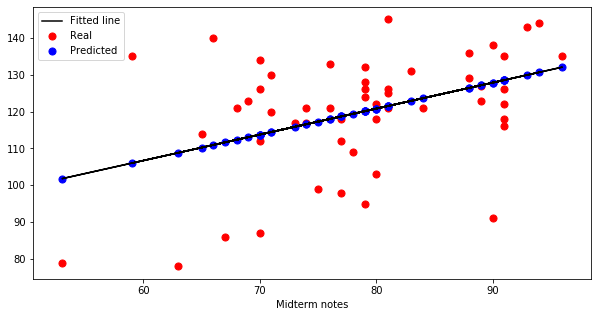

In [22]:
data_df['Predicted'] = res_OLS.predict(Xa)
print(data_df[['Midterm','Final', 'Predicted']].head())
fig, axes = plt.subplots(figsize=(10,5)) 
axes.scatter(data_df['Midterm'], data_df['Final'], s=50, c='r', label='Real')
axes.scatter(data_df['Midterm'], data_df['Predicted'], s=50, c='b', label='Predicted')
axes.plot(data_df['Midterm'], params[0]+params[1]*data_df['Midterm'], 'k', label='Fitted line')
axes.set_xlabel('Midterm notes')
axes.legend()

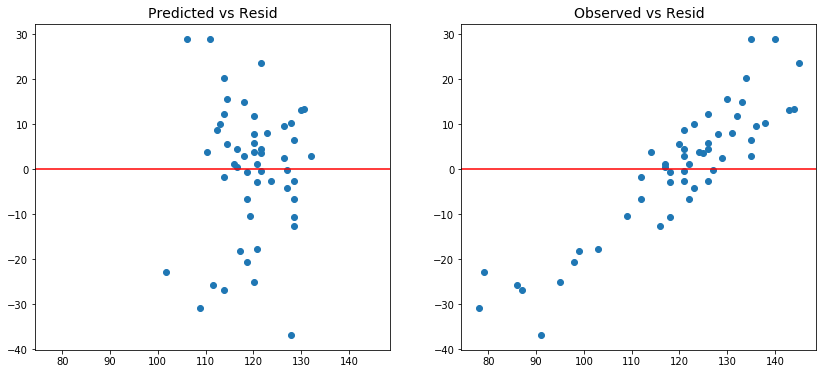

In [24]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 6), sharex=True)
axes[0].scatter(data_df['Predicted'], res_OLS.resid); axes[0].set_title('Predicted vs Resid', fontsize=14)
axes[0].axhline(y=0, c='r')
axes[1].scatter(data_df['Final'], res_OLS.resid); axes[1].set_title('Observed vs Resid', fontsize=14)
axes[1].axhline(y=0, c='r')

It turns out that the first plot is what we should be looking at, and the second plot
is misleading. This can be understood using probability theory (from the regression model, the errors $\epsilon$ should be independent of the predictors x, not the data y) but a perhaps more convincing demonstration uses fake data, as we now illustrate. 

In [27]:
a, b, s = 65, 0.7, 15
n = len(data_df['Midterm'])
y_fake = a + b*data_df['Midterm'] + np.random.normal(loc=0, scale=s, size=n)
model = sm.OLS(y_fake, Xa)
res_OLS = model.fit()
params = res_OLS.params
res_OLS.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Midterm   R-squared:                       0.145
Model:                            OLS   Adj. R-squared:                  0.128
Method:                 Least Squares   F-statistic:                     8.459
Date:                Fri, 30 Oct 2020   Prob (F-statistic):            0.00541
Time:                        15:00:56   Log-Likelihood:                -215.51
No. Observations:                  52   AIC:                             435.0
Df Residuals:                      50   BIC:                             438.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         65.8647     17.914      3.677      0.001      29.882     101.847
Midterm        0.6581      0.226      2.908      0.005       0.204       1.113
==============================================================================
Omnibus:                        3.060   Durbin-Watson:                   2.209
Prob(Omnibus):                  0.217   Jarque-Bera (JB):                1.665
Skew:                           0.112   Prob(JB):                        0.435
Kurtosis:                       2.152   Cond. No.                         657.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

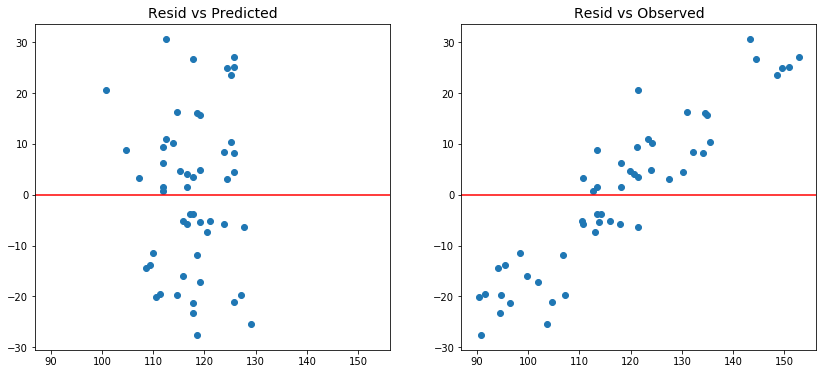

In [28]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 6), sharex=True)
axes[0].scatter(res_OLS.predict(Xa), res_OLS.resid); axes[0].set_title('Resid vs Predicted', fontsize=14)
axes[0].axhline(y=0, c='r')
axes[1].scatter(y_fake, res_OLS.resid); axes[1].set_title('Resid vs Observed', fontsize=14)
axes[1].axhline(y=0, c='r')

## Simulating from the fitted model and comparing to actual data (outliers, long-tailed distribution)

**Example: comparing data to replications from a fitted normal distribution**

The most fundamental way to check model fit is to display replicated datasets and compare them to the actual data. Here we illustrate with a simple case, from a famous historical dataset that did not fit the normal distribution. The goal of this example is to demonstrate how the lack of fit can be seen using predictive replications. Figure 8.3 shows the data, a set of measurements taken by Simon Newcomb in
1882 as part of an experiment to estimate the speed of light. We (**inappropriately**) fit a normal distribution to these data, which in the regression context can be done by fitting a linear regression with no predictors

In [29]:
data_df = pd.read_csv('Data/lightspeed.dat', sep=" ", header=None, skiprows=3)
light_speed = np.concatenate(data_df.values) # convert to array
y = light_speed[~np.isnan(light_speed)] # remove nans
model = sm.OLS(y, np.ones(len(y)))
res_OLS = model.fit()
params = res_OLS.params
res_OLS.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                       nan
Date:                Fri, 30 Oct 2020   Prob (F-statistic):                nan
Time:                        15:19:27   Log-Likelihood:                -249.86
No. Observations:                  66   AIC:                             501.7
Df Residuals:                      65   BIC:                             503.9
Df Model:                           0                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         26.2121      1.323     19.818      0.000      23.571      28.854
==============================================================================
Omnibus:                       98.931   Durbin-Watson:                   2.310
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2139.175
Skew:                          -4.493   Prob(JB):                         0.00
Kurtosis:                      29.403   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

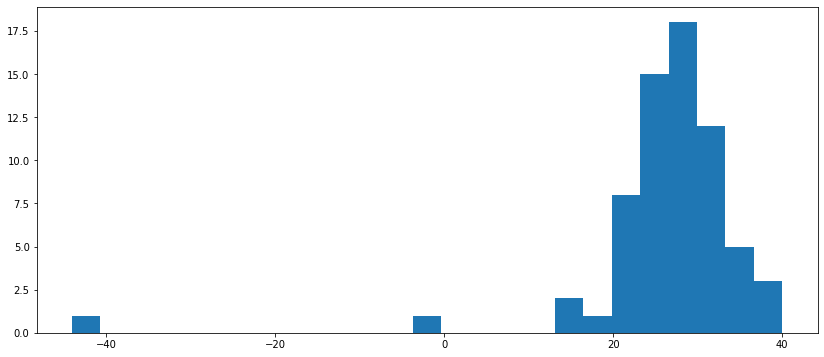

In [30]:
fig, axes = plt.subplots(nrows=1, figsize=(14,6))
hist = axes.hist(y, bins=25)

In [31]:
def sim(model_results, size=10):
    """
    Simulate samples from coefficients of a linear model (analogous to R function sim() from Gelman and Hill).
    The standard deviation of residuals $\hat{\sigma}$ is chi-squared while the model coefficients
    $\hat{beta}$ are normal.
    Both uncertainty in $\hat{\sigma}$ and $\hat{beta}$ is taken into account.
    PARAMETERS:
        model_results : the results object returned from `fit()` method of a statsmodels linear model class
        size : int the number of simulations to run
    RETURN:
        beta_sim : np.array of shape [size, len(model_results.params)]
    """
    beta_hat = model_results.params
    cov_beta = model_results.cov_params()
    df = model_results.df_resid
    sigma_hat = np.sqrt(np.sum(model_results.resid**2) / df)
    V_beta = cov_beta / sigma_hat**2
    X = np.random.chisquare(df, size=size)
    sigma_sim = sigma_hat * np.sqrt(df / X)
    beta_sim = [np.random.multivariate_normal(beta_hat, (sigma_sim[i]**2) * V_beta) for i in range(size)]
    return np.array(beta_sim), np.array(sigma_sim)

The next step is to simulate 1000 replications from the parameters in the fitted model. Then, we can then use these simulations to create 1000 fake datasets of 66 observations each:

In [32]:
n_sims = 1000
beta_sim, sigma_sim = sim(res_OLS, size=n_sims)
n = len(y)
y_sims = np.zeros((n_sims, n))
for s in range(n_sims):
    y_sims[s, :] = np.random.normal(loc=beta_sim[s], scale=sigma_sim[s], size=n)

In [33]:
fig, axes = plt.subplots(nrows=5, ncols=4, figsize=(20,10), sharex=True)
for i in range(5):
    for j in range(4):
        axes[i][j].hist(y, bins=25, color='orange')
        axes[i][j].hist(y_sims[np.random.randint(n_sims),:], bins=25, color='k')
        

### Smallest observation in each simulation

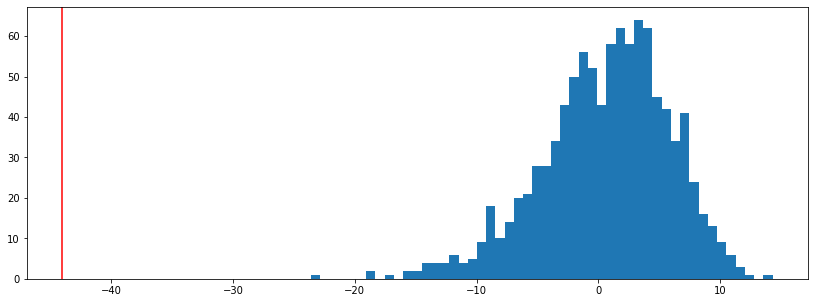

In [34]:
fig, axes = plt.subplots(nrows=1, figsize=(14,5))
hist = axes.hist(np.min(y_sims, axis=1), bins=50)
axes.axvline(x=np.min(y), c='r')

The smallest observations in each of the hypothetical replications are all much larger than Newcomb’s smallest observation, which is indicated by a vertical line on the graph. The normal model clearly does not capture the variation that Newcomb observed. A revised model might use an asymmetric contaminated normal distribution or a symmetric long-tailed distribution in place of the normal measurement model.

### Zeroes in count data (the model does not represent the zeroes percentage)

For a more complicated example, we consider a study of the effect of integrated pest management on reducing cockroach levels in urban apartments. In this experiment, the treatment and control were applied to 160 and 104 apartments, respectively, and the outcome measurement $y_i$ in each apartment i was the number of roaches caught in a set of traps. Different apartments had traps for different numbers of days, and we label as $u_i$ the number of trap-days. The natural model for the roach counts is then $y_i$ ∼ $Poisson(u_i e^{X_i \beta})$, where X represents the regression predictors (in this case, a pre-treatment roach level, a treatment indicator, and an indicator for whether the apartment is in a “senior” building restricted to the elderly, and the constant term). The logarithm of the exposure, log($u_i$), plays the role of the “offset” in the Poisson regression (see model (6.3) on page 111).

In [134]:
data_df = pd.read_csv('data/roaches/roachdata.csv')
data_df.head()

Unnamed: 0    y  roach1  treatment  senior  exposure2
0           1  153  308.00          1       0   0.800000
1           2  127  331.25          1       0   0.600000
2           3    7    1.67          1       0   1.000000
3           4    7    3.00          1       0   1.000000
4           5    0    2.00          1       0   1.142857

In [146]:
y = data_df['y']
Xa = sm.add_constant(data_df[['roach1','treatment','senior']])  # add ones vector
model = sm.GLM(y, Xa, family=sm.families.Poisson(), offset=np.log(data_df['exposure2']))
res_Poisson = model.fit()
params = res_Poisson.params
res_Poisson.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                      y   No. Observations:                  262
Model:                            GLM   Df Residuals:                      258
Model Family:                 Poisson   Df Model:                            3
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -6092.0
Date:                Wed, 11 Nov 2020   Deviance:                       11429.
Time:                        15:12:19   Pearson chi2:                 1.69e+04
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.0892      0.021    145.486      0.000       3.048       3.131
roach1         0.0070   8.87e-05     78.685      0.000       0.007       0.007
treatment     -0.5167      0.025    -20.887      0.000      -0.565      -0.468
senior        -0.3799      0.033    -11.367      0.000      -0.445      -0.314
==============================================================================
"""

The treatment appears to be effective in reducing roach counts—we shall return to this issue in a later chapter with a fuller exploration of this study. 

For now, we are simply interested in evaluating the model as a description of the data, without worrying about causal issues or the interpretation of the coefficients. Comparing the data, y, to a replicated dataset, y_rep. How well does this model fit the data? We explore by simulating a replicated dataset y_rep that might be seen if the model were true and the study were performed again:

In [147]:
n = len(y)
y_hat = data_df['exposure2']*np.exp(np.dot(Xa, params))
y_rep = np.random.poisson(y_hat, size=n)

We can compare the replicated data yrep to the original data y in various ways. We illustrate with a simple test of the number of zeroes in the data, which reveals that 36% of the observed data points, but none of the replicated data points, equal zero. **This suggests a potential problem with the model: in reality, many apartments have zero roaches, but this would not be happening if the model were true, at least to judge from one simulation.**

In [27]:
print(np.mean(y==0))
print(np.mean(y_rep==0))

0.35877862595419846
0.0


Comparing the data y to 1000 replicated datasets y_rep. To perform this model check more formally, we simulate 1000 replicated datasets y_rep, which we store in a matrix:

In [23]:
def sim_Poisson(model_results, size=10):
    """
    Simulate samples from coefficients of a linear model (analogous to R function sim() from Gelman and Hill).
    The standard deviation of residuals $\hat{\sigma}$ is chi-squared while the model coefficients
    $\hat{beta}$ are normal.
    Both uncertainty in $\hat{\sigma}$ and $\hat{beta}$ is taken into account.
    PARAMETERS:
        model_results : the results object returned from `fit()` method of a statsmodels linear model class
        size : int the number of simulations to run
    RETURN:
        beta_sim : np.array of shape [size, len(model_results.params)]
    """
    beta_hat = model_results.params
    cov_beta = model_results.cov_params()
    df = model_results.df_resid
    sigma_hat = np.sqrt(np.sum(model_results.resid_deviance**2) / df)
    V_beta = cov_beta / sigma_hat**2
    X = np.random.chisquare(df, size=size)
    sigma_sim = sigma_hat * np.sqrt(df / X)
    beta_sim = [np.random.multivariate_normal(beta_hat, (sigma_sim[i]**2) * V_beta) for i in range(size)]
    return np.array(beta_sim), np.array(sigma_sim)

In [36]:
n_sims = 1000
beta_sim, _ = sim_Poisson(res_Poisson, size=n_sims)
y_rep = np.zeros((n_sims, n))
for s in range(n_sims):
    y_hat = data_df['exposure2']*np.exp(np.dot(Xa, beta_sim[s,:]))
    y_rep[s,:] = np.random.poisson(y_hat, size=n)
    

For each of these replications, we then compute a test statistic: the proportion of zeroes in the (hypothetical) dataset. The 1000 values of test.rep vary from 0 to 0.008—all of which are much lower than the observed test statistic of 0.36. **Thus the Poisson regression model does not replicate the frequency of zeros in the data.**

In [37]:
print(np.mean(np.mean(y_rep==0, axis=1)))


0.0007671755725190839


### Checking the overdispersed model
We probably should have just started with an overdispersed Poisson Regression.

_In statsmodels the overdispersed Poisson can be implemented as a negative binomial (they are equivalent)._
 * There is dedicated class in the API or the GLM class can be used. However in the GLM class the overdispersion parameter seem to be fixed and not estimated (not sure about it). So I chose the dedicated class.
 * The loglike_method parameter controls how the overdispersion is modeled. 'nb1' should correspond to the one used in the book.

In [148]:
Xa = sm.add_constant(data_df[['roach1', 'treatment', 'senior']])  # add ones vector
model_overdisp_poisson = sm.NegativeBinomial(endog=y, exog=Xa, loglike_method='nb1', offset=np.log(data_df['exposure2']).values)
res_Poisson = model_overdisp_poisson.fit(method='bfgs', maxiter=100)
params = res_Poisson.params
res_Poisson.summary()

Optimization terminated successfully.
         Current function value: 3.360137
         Iterations: 54
         Function evaluations: 90
         Gradient evaluations: 90


<class 'statsmodels.iolib.summary.Summary'>
"""
                     NegativeBinomial Regression Results                      
==============================================================================
Dep. Variable:                      y   No. Observations:                  262
Model:               NegativeBinomial   Df Residuals:                      258
Method:                           MLE   Df Model:                            3
Date:                Wed, 11 Nov 2020   Pseudo R-squ.:                 0.04650
Time:                        15:12:28   Log-Likelihood:                -880.36
converged:                       True   LL-Null:                       -923.29
Covariance Type:            nonrobust   LLR p-value:                 1.685e-18
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.0037      0.156     19.298      0.000       2.699       3.309
roach1         0.0068      0.001     11.874      0.000       0.006       0.008
treatment     -0.2749      0.146     -1.889      0.059      -0.560       0.010
senior        -0.4825      0.180     -2.681      0.007      -0.835      -0.130
alpha         80.0400     11.912      6.719      0.000      56.693     103.387
==============================================================================
"""

The parametrization of negative binomial distribution in scipy and numpy requires a change of variables with respect to the mean and variance obtained from the estimation.

In [149]:
def convert_params(mu, theta):
    """
    Convert mean/dispersion parameterization of a negative binomial to the ones numpy/scipy supports.
    See https://en.wikipedia.org/wiki/Negative_binomial_distribution#Alternative_formulations
    """
    r = theta
    var = mu + 1 / r * mu ** 2
    p = (var - mu) / var
    return r, 1 - p

0.35993129770992366


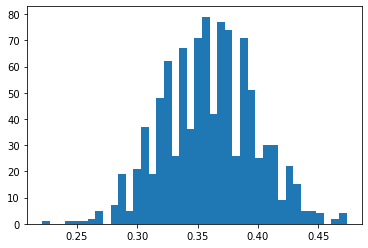

In [150]:
from utils import sim

n_sims = 1000
beta_sim, _ = sim(res_Poisson, size=n_sims)
y_rep = np.zeros((n_sims, n))
for s in range(n_sims):
    y_hat = data_df['exposure2'].values*np.exp(np.dot(Xa, beta_sim[s,:4]))
    alpha_hat = beta_sim[s, -1] + 1
    theta = y_hat / (alpha_hat - 1)
    r, p = convert_params(y_hat, theta)
    y_rep[s,:] = np.random.negative_binomial(r, p, size=n)
    
print(np.mean(np.mean(y_rep==0, axis=1)))
fig, ax = plt.subplots()
ax.hist(np.mean(y_rep==0, axis=1), bins=40);

### Check for time series models

In [105]:
data_df = pd.read_csv('data/unemployment/unemployment.dat', delim_whitespace=True, header=0, thousands=',', decimal='.')

<AxesSubplot:xlabel='year', ylabel='unemployed.pct'>

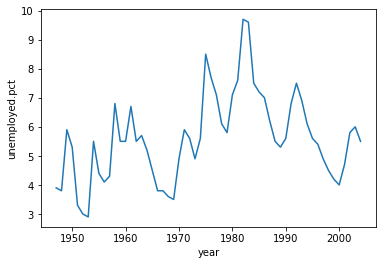

In [111]:
import seaborn as sns

fig, ax = plt.subplots()
sns.lineplot(data=data_df, y='unemployed.pct', x='year', ax=ax)

In [114]:
ylag = data_df['unemployed.pct'][:-1].values
y = data_df['unemployed.pct'][1:].values
ylag = sm.add_constant(ylag)
model = sm.OLS(endog=y, exog=ylag)
res = model.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.574
Model:                            OLS   Adj. R-squared:                  0.566
Method:                 Least Squares   F-statistic:                     74.10
Date:                Wed, 11 Nov 2020   Prob (F-statistic):           9.01e-12
Time:                        12:57:25   Log-Likelihood:                -79.033
No. Observations:                  57   AIC:                             162.1
Df Residuals:                      55   BIC:                             166.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.4346      0.505      2.843      0.006       0.424       2.446
x1             0.7489      0.087      8.608      0.000       0.575       0.923
==============================================================================
Omnibus:                       10.939   Durbin-Watson:                   1.756
Prob(Omnibus):                  0.004   Jarque-Bera (JB):               10.806
Skew:                           0.979   Prob(JB):                      0.00450
Kurtosis:                       3.845   Cond. No.                         23.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [119]:
n_sims = 1000
beta_sim, sigma_sim = sim(res, size=n_sims)
n = len(y) + 1
y_sims = np.zeros((n_sims, n))
for s in range(n_sims):
    y_sims[s, 0] = data_df['unemployed.pct'][0]
    for t in range(1, n):
        prediction = np.array([1, y_sims[s, t-1]]) @ beta_sim[s]
        y_sims[s, t] = np.random.normal(loc=prediction, scale=sigma_sim[s], size=1)

In [129]:
fig, axs = plt.subplots(nrows=3, ncols=5, figsize=[12, 6], sharey=True, sharex=True)
chosen_sims = np.random.choice(n_sims, size=15)
for i in range(3):
    for j in range(5):
        axs[i, j].plot(data_df.year, y_sims[chosen_sims[j+5*i], :])
        if i==2:
            axs[i, j].set_xlabel('year')
        if j==0:
            axs[i, j].set_ylabel('unemployment [%]')
plt.tight_layout()